In [104]:
import pandas as pd
import numpy as np
import spacy

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

# import morfeusz2

import matplotlib.pyplot as plt
import seaborn as sns

#from sentence_transformers import SentenceTransformer
import umap
import hdbscan

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import utils
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

import re

from wordcloud import WordCloud
import shap

from nltk import ngrams
import nltk

import scipy
from sklearn.model_selection import cross_validate

from utils import *

from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=7,progress_bar=True)

from parallelbar import progress_map


from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Load data

In [105]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

In [106]:
df = df[ df['assestment'] != 'brak' ]

In [107]:
df['assestment'].value_counts()

Prawda               2831
falsz                1308
Fałsz                1136
zbity_zegar           707
Manipulacja           705
raczej_falsz          288
polprawda             254
Nieweryfikowalne      236
prawda                179
blisko_prawdy          93
Częściowy fałsz       9
Name: assestment, dtype: int64

In [108]:
df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df['assestment'].value_counts()

Fałsz               3439
Prawda              3103
Manipulacja          968
Nieweryfikowalne     236
Name: assestment, dtype: int64

In [109]:
df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

In [110]:
df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

In [112]:
y_train = df.copy()['assestment']#.loc[id_train,:].copy()['assestment']

## Create POS ngrams embeddings

In [113]:
words =  sum(df['TEXT_POS'].str.split(' ').values.tolist(), [])

In [114]:
n1 = (pd.Series(nltk.ngrams(words, 1)).value_counts()) 
n2 = (pd.Series(nltk.ngrams(words, 2)).value_counts()) 
n3 = (pd.Series(nltk.ngrams(words, 3)).value_counts()) 

In [115]:
n1 = n1[n1>5]
n2 = n2[n2>5]
n3 = n3[n3>5]

In [116]:
print(
    n1.shape,
    n2.shape,
    n3.shape
)

(18,) (260,) (1955,)


In [117]:
X_train_df = df.copy()

In [118]:
pos = {}
y = y_train.values

for n in tqdm(n1.index.tolist() + n2.index.tolist() + n3.index.tolist()):
    x = X_train_df['TEXT_POS'].str.count(' '.join(n)) / X_train_df['TEXT_POS'].str.split(' ').str.len()
    
    r = scipy.stats.pearsonr(x.values, y)[0]
    
    if r > 0.05:
        pos[' '.join(n)] = x
        pos[' '.join(n)].name = ' '.join(n)

100%|███████████████████████████████████████| 2233/2233 [02:33<00:00, 14.50it/s]


In [119]:
X_train_df = pd.concat( [X_train_df] + list( pos.values() ), axis=1 )

In [120]:
X_train_df.shape

(6542, 65)

In [121]:
pos.keys()

dict_keys(['ADP', 'PROPN', 'X', 'NUM', 'SYM', 'X PUNCT', 'PROPN VERB', 'NUM X', 'NUM NOUN', 'NUM SYM', 'ADP NUM', 'PART NUM', 'PUNCT NUM', 'VERB NUM', 'NOUN NUM', 'ADJ X', 'SYM PUNCT', 'SYM NOUN', 'NUM PROPN', 'ADV NUM', 'SYM PROPN', 'X NUM', 'NUM X PUNCT', 'NUM NOUN PUNCT', 'ADJ X PUNCT', 'ADP PROPN VERB', 'PART NUM X', 'ADP NUM NOUN', 'X PUNCT ADP', 'PUNCT NUM X', 'NUM SYM PUNCT', 'VERB NUM X', 'NOUN ADP NUM', 'NUM X NOUN', 'PART NUM NOUN', 'NUM SYM NOUN', 'NOUN PUNCT NUM', 'VERB PART NUM', 'ADP NOUN NUM', 'PUNCT NUM SYM', 'NOUN VERB NUM', 'PROPN PROPN ADP', 'NUM SYM PROPN', 'ADP NUM SYM', 'VERB NUM SYM', 'CCONJ NUM X'])

In [122]:
col_use = (['sentiment_all', 'sentiment_avg', 'uniq_words', 'uniq_lemm', 'err', 'net', 
           'ADJ', 'ADV', 'NOUN', 
           'words_start_upper', 'words_full_upper', 'exclamation_marks', 'question_marks', 'upper_letters', 'chars'] 
        +
           ['ADP', 'PROPN', 'X', 'NUM', 'SYM', 'X PUNCT', 'PROPN VERB', 'NUM X', 'NUM NOUN', 'NUM SYM', 'ADP NUM', 'PART NUM', 'PUNCT NUM', 'VERB NUM', 'NOUN NUM', 'ADJ X', 'SYM PUNCT', 'SYM NOUN', 'NUM PROPN', 'ADV NUM', 'SYM PROPN', 'X NUM', 'NUM X PUNCT', 'NUM NOUN PUNCT', 'ADJ X PUNCT', 'ADP PROPN VERB', 'PART NUM X', 'ADP NUM NOUN', 'X PUNCT ADP', 'PUNCT NUM X', 'NUM SYM PUNCT', 'VERB NUM X', 'NOUN ADP NUM', 'NUM X NOUN', 'PART NUM NOUN', 'NUM SYM NOUN', 'NOUN PUNCT NUM', 'VERB PART NUM', 'ADP NOUN NUM', 'PUNCT NUM SYM', 'NOUN VERB NUM', 'PROPN PROPN ADP', 'NUM SYM PROPN', 'ADP NUM SYM', 'VERB NUM SYM', 'CCONJ NUM X'])

In [123]:
X_test_df = df.copy()

pos_test = {}

for n in tqdm(list(pos.keys())):
    x = X_test_df['TEXT_POS'].str.count(n) / X_test_df['TEXT_POS'].str.split(' ').str.len()
    
    pos_test[n] = x
    pos_test[n].name = n

X_test_df = pd.concat( [X_test_df] + list( pos_test.values() ), axis=1 )

100%|███████████████████████████████████████████| 46/46 [00:03<00:00, 11.91it/s]


In [170]:
X_test_df.shape

(6542, 65)

## Undersampling data

In [124]:
tasks = X_train_df['text_clean'].values.tolist()
result = progress_map(tokenize, tasks, n_cpu=7, chunk_size=1, core_progress=True)

X_train_df['words'] = result

Core 1:   0%|          | 0/935 [00:00<?, ?it/s]

Core 2:   0%|          | 0/935 [00:00<?, ?it/s]

Core 3:   0%|          | 0/935 [00:00<?, ?it/s]

Core 4:   0%|          | 0/935 [00:00<?, ?it/s]

Core 5:   0%|          | 0/935 [00:00<?, ?it/s]

Core 6:   0%|          | 0/935 [00:00<?, ?it/s]

Core 7:   0%|          | 0/935 [00:00<?, ?it/s]

In [130]:
X_train_df = X_train_df[X_train_df['words'].apply(len)>0]

In [131]:
y_train = y_train[y_train.index.isin(X_train_df.index)]

In [132]:
logisticRegr = LogisticRegression(max_iter=1000)

X_train = X_train_df[col_use].sort_index().values

# undersampling

n_lower = y_train.value_counts().min()

# np.random.seed(111)
# index_0 = np.random.choice(y_train[y_train==0].index, n_lower, replace=False)
# index_1 = np.random.choice(y_train[y_train==1].index, n_lower, replace=False)

y_train_b = y_train.sort_index()
X_train_b = X_train_df[col_use+['words']].sort_index().reset_index()#.values

## Analysis words frequencies

In [133]:
df_one = X_train_b.copy()

# df_one = df_one[['tokens']].reset_index().explode('tokens')
df_one = df_one[['words']].reset_index().explode('words')
df_one['n'] = 1

In [134]:
df_one['tokens'] = df_one['words'].apply( lambda x: re.sub(r"[`'-.’0-9]", "", x) )

In [135]:
# df_one_trn = df_one.loc[id_train,:].copy()
# df_one_tst = df_one.loc[id_test,:].copy()

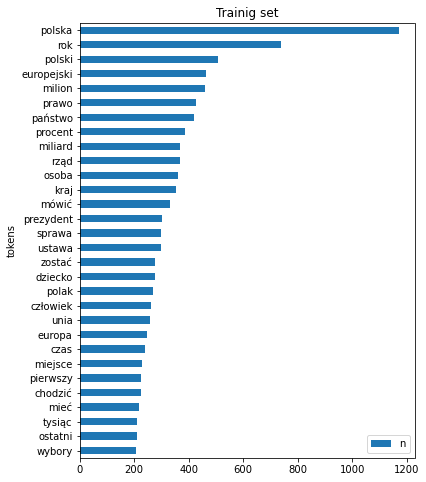

In [136]:
df_one = df_one[df_one['tokens'].str.len() > 1]

f, ax = plt.subplots(figsize=(6,8));
df_one.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.title('Trainig set')
plt.show()

### Filter out extra stop words

In [137]:
extra_stop_words = set(['polska', 'rok', 'polski', 'europejski', 'milion'] 
                       + 
                       df_one.groupby('tokens').agg(n=('n','sum')).query('n==1').index.values.tolist())

In [138]:
def filter_stop_words(words, stop_words = extra_stop_words):
    out = [x for x in words if x not in stop_words]
    return out

tasks = X_train_b['words'].values.tolist()
result = progress_map(filter_stop_words, tasks, n_cpu=7, chunk_size=1, core_progress=True)

X_train_b['words_clean'] = result

Core 1:   0%|          | 0/935 [00:00<?, ?it/s]

Core 2:   0%|          | 0/935 [00:00<?, ?it/s]

Core 3:   0%|          | 0/935 [00:00<?, ?it/s]

Core 4:   0%|          | 0/935 [00:00<?, ?it/s]

Core 5:   0%|          | 0/935 [00:00<?, ?it/s]

Core 6:   0%|          | 0/935 [00:00<?, ?it/s]

Core 7:   0%|          | 0/935 [00:00<?, ?it/s]

### LDA optimization

https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin

In [139]:
dictionary = gensim.corpora.Dictionary(X_train_b['words_clean'].values)
bow_corpus = [dictionary.doc2bow(doc) for doc in X_train_b['words_clean'].values]

# Considering 1-15 topics, as the last is cut off
num_keywords = 15
num_topics = list(range(1,num_keywords+2))

LDA_models = {}
LDA_topics = {}
for i in tqdm(num_topics):
    LDA_models[i] = gensim.models.LdaMulticore(corpus=bow_corpus,
                                             id2word=dictionary,
                                             num_topics=i,
#                                              update_every=1,
#                                              chunksize=len(bow_corpus),
                                             passes=10,
#                                              alpha='auto',
                                             random_state=111,
                                             workers=7)
    
    

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

100%|███████████████████████████████████████████| 16/16 [04:01<00:00, 15.12s/it]


In [140]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [141]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [142]:
coherences = [CoherenceModel(model=LDA_models[i], 
                             texts=X_train_b['words_clean'].values, 
                             dictionary=dictionary, 
                             coherence='c_v').get_coherence()\
              for i in tqdm(num_topics[:-1])]

100%|███████████████████████████████████████████| 15/15 [00:22<00:00,  1.52s/it]


In [143]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] 
# limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] 
# choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

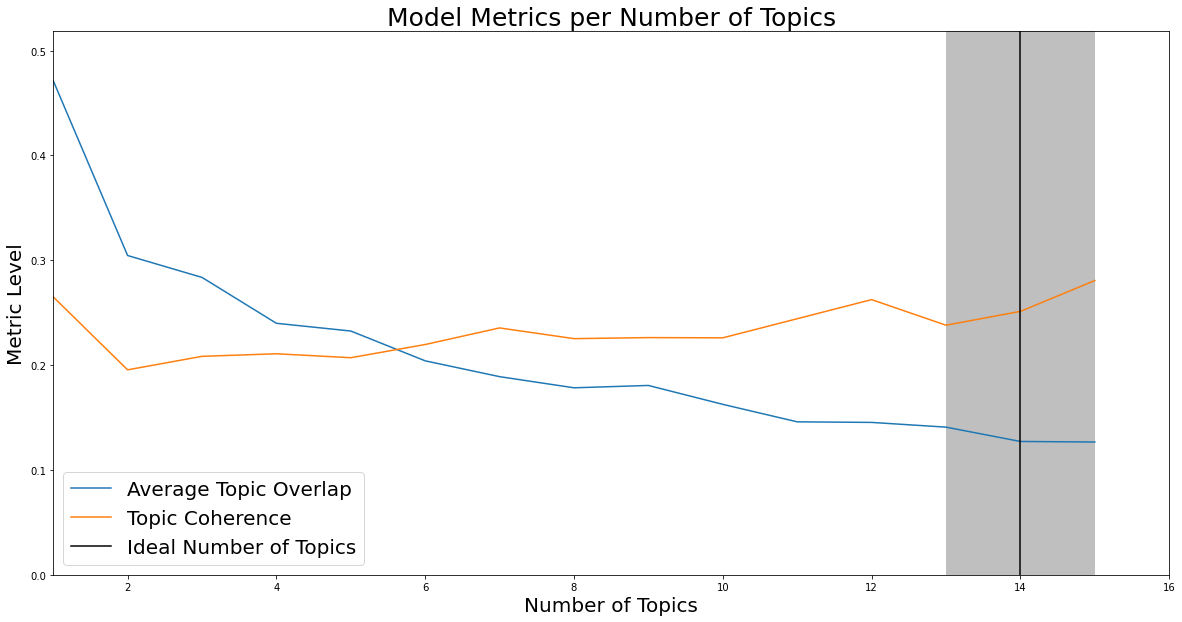

In [144]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

### Hierarchical Dirichlet Process 

In [145]:
#TO DO

## Final number of topics

In [147]:
ideal_topic_num = 15

In [148]:
dictionary = gensim.corpora.Dictionary(X_train_b['words_clean'].values)

bow_corpus = [dictionary.doc2bow(doc) for doc in X_train_b['words_clean'].values]


lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = ideal_topic_num, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   random_state=111,
                                   workers = 7)

topics = []

for line in tqdm(X_train_b['words_clean'].values):
    line_bow = dictionary.doc2bow(line)
    doc_lda = lda_model[line_bow]
    
    topics.append( max(doc_lda, key=lambda x:x[1])[0] )

X_train_b['topic'] = topics

100%|█████████████████████████████████████| 6541/6541 [00:04<00:00, 1436.13it/s]


In [149]:
x=lda_model.show_topics(num_topics=ideal_topic_num, num_words=5)

twords={}
for topic,word in x:
    print(topic, word)

0 0.011*"polak" + 0.010*"podatek" + 0.009*"kraj" + 0.008*"chodzić" + 0.008*"unia"
1 0.019*"człowiek" + 0.011*"dziecko" + 0.009*"rząd" + 0.008*"osoba" + 0.007*"tysiąc"
2 0.015*"państwo" + 0.011*"prawo" + 0.008*"mówić" + 0.008*"procent" + 0.007*"komisja"
3 0.017*"miejsce" + 0.011*"prawo" + 0.007*"osoba" + 0.007*"praca" + 0.006*"rząd"
4 0.037*"miliard" + 0.017*"budżet" + 0.013*"euro" + 0.009*"państwo" + 0.008*"rocznie"
5 0.013*"procent" + 0.006*"europa" + 0.006*"ustawa" + 0.005*"prezydent" + 0.004*"wiek"
6 0.025*"trybunał" + 0.019*"konstytucyjny" + 0.017*"konstytucja" + 0.014*"prezydent" + 0.013*"sędzia"
7 0.010*"kraków" + 0.008*"osoba" + 0.006*"tysiąc" + 0.006*"prawo" + 0.006*"miasto"
8 0.016*"ostatni" + 0.013*"ciąg" + 0.010*"rząd" + 0.010*"miliard" + 0.009*"pierwszy"
9 0.010*"państwo" + 0.007*"mówić" + 0.007*"wybory" + 0.007*"procent" + 0.006*"partia"
10 0.009*"osoba" + 0.007*"czas" + 0.007*"państwo" + 0.005*"polak" + 0.005*"chodzić"
11 0.011*"dziecko" + 0.008*"projekt" + 0.007*"rząd" +

In [150]:
X_train_b['topic'].value_counts()

2     561
6     546
13    531
4     516
11    498
8     440
1     438
3     437
5     410
7     381
14    372
0     371
10    355
9     345
12    340
Name: topic, dtype: int64

### Prepare CV

In [153]:
cv_fold = []

for i in X_train_b['topic'].unique().reshape(5,-1):
    train_cv = X_train_b.index[ ~np.isin(X_train_b["topic"], i) ].values
    test_cv = X_train_b.index[ np.isin(X_train_b["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])

In [154]:
X_train_v = X_train_b[col_use].values

In [158]:
logisticRegr = LogisticRegression(max_iter=5000)

scoring = ['accuracy', 'precision', 'recall', 'f1']

results = cross_validate(estimator=logisticRegr,
                       X=X_train_v,
                       y=y_train_b.values,
                       cv=cv_fold, #10,
                       scoring=scoring,
                       return_train_score=True)

metrics = {
    "Accuracy": results['test_accuracy'].mean(),
#     "Accuracy Std": results['test_accuracy'].std(),
    "Precision": results['test_precision'].mean(),
#     "Precision Std": results['test_precision'].std(),
    "Recall": results['test_recall'].mean(),
#     "Recall Std": results['test_recall'].std(),
    "F1 Score": results['test_f1'].mean(),
#     "F1 Score Std": results['test_f1'].std()
    }

metrics

{'Accuracy': 0.621404753114134,
 'Precision': 0.6303232068843686,
 'Recall': 0.4879373862245438,
 'F1 Score': 0.5490204920592857}

In [159]:
scoring = ['accuracy', 'precision', 'recall', 'f1']

results = cross_validate(estimator=logisticRegr,
                       X=X_train_v,
                       y=y_train_b.values,
                       cv=5, 
                       scoring=scoring,
                       return_train_score=True)

metrics = {
    "Accuracy": results['test_accuracy'].mean(),
#     "Accuracy Std": results['test_accuracy'].std(),
    "Precision": results['test_precision'].mean(),
#     "Precision Std": results['test_precision'].std(),
    "Recall": results['test_recall'].mean(),
#     "Recall Std": results['test_recall'].std(),
    "F1 Score": results['test_f1'].mean(),
#     "F1 Score Std": results['test_f1'].std()
    }

metrics

{'Accuracy': 0.6064960763287801,
 'Precision': 0.6403767086006094,
 'Recall': 0.47526518102955684,
 'F1 Score': 0.5285288485837581}

## One-hot embeddings

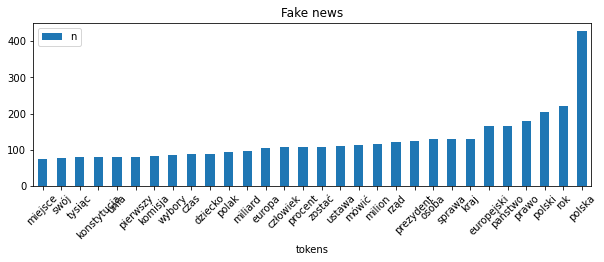

In [161]:
f, ax = plt.subplots(figsize=(10,3));
df_one[
    df_one['index'].isin(y_train_b[y_train_b==0].index.values)
].groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='bar', ax=ax)
plt.xticks(rotation = 45) 
plt.title('Fake news')
plt.show()

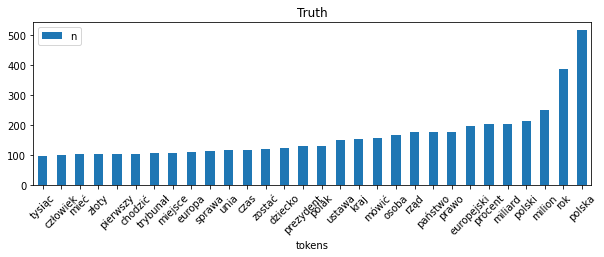

In [162]:
f, ax = plt.subplots(figsize=(10,3));
df_one[
    df_one['index'].isin(y_train_b[y_train_b==1].index.values)
].groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='bar', ax=ax)
plt.xticks(rotation = 45) 
plt.title('Truth')
plt.show()

In [163]:
df_one

,index,words,n,tokens
0,0,udzielć,1,udzielć
0,0,bank,1,bank
0,0,centralny,1,centralny
0,0,ukraina,1,ukraina
0,0,swapa,1,swapa
...,...,...,...,...
6540,6540,dziecko,1,dziecko
6540,6540,edukacja,1,edukacja
6540,6540,pierwszeństwo,1,pierwszeństwo
6540,6540,ukraińców,1,ukraińców


In [171]:
df_one_trn_p = (
    df_one[['index','tokens','n']]
    .drop_duplicates()
    .pivot(index='index', columns='tokens', values='n')
    .fillna(0)
)
df_one_trn_p.shape

(6541, 12914)

In [172]:
df_one_trn_p = df_one_trn_p.loc[:, ~df_one_trn_p.columns.isin( extra_stop_words )]

In [173]:
df_one_trn_p = df_one_trn_p.loc[:, (df_one_trn_p.sum() > 1)]
df_one_trn_p.shape

(6541, 5907)

In [174]:
df_one_trn_p_20 = df_one_trn_p.loc[:, (df_one_trn_p.sum() > 20)]
df_one_trn_p_20.shape

(6541, 725)

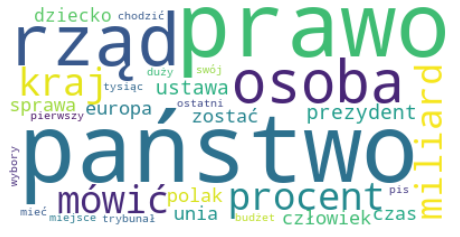

In [175]:
wordcloud = WordCloud(background_color='white',
                      max_words=30).generate_from_frequencies(df_one_trn_p.sum())

f, ax = plt.subplots(figsize=(8,8));
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [176]:
def get_tfidf(df):
    tf = df.divide(df.sum(1).values, axis=0)
    idf = np.log10( (df.shape[0]+1)/(df.sum()+1) )
    tfidf = tf*idf
    gtf = np.log10( df.sum()+1 )
    tfidf_kindof = gtf * idf
    
    return tfidf, tfidf_kindof.sort_values(ascending=False)

In [181]:
# tfidf_fn, tfidf_ko_fk =  get_tfidf(df_one_trn_p[y_train.sort_index()==0])
# tfidf_t, tfidf_ko_t =  get_tfidf(df_one_trn_p[y_train.sort_index()==1])

In [182]:
# wordcloud = WordCloud(background_color='white',
#                       max_words=50).generate_from_frequencies(tfidf_ko_t)

# f, ax = plt.subplots(figsize=(10,6));
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.title('Truth')
# plt.axis('off')
# plt.show()

In [183]:
# wordcloud = WordCloud(background_color='white',
#                       max_words=50).generate_from_frequencies(tfidf_ko_fk)

# f, ax = plt.subplots(figsize=(10,6));
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.title('Fake news')
# plt.axis('off')
# plt.show()

In [184]:
logisticRegr = LogisticRegression()

X_train = df_one_trn_p.sort_index().values

logisticRegr.fit(X_train, y_train_b.sort_index().values)

LogisticRegression()

In [185]:
# train_predictions = logisticRegr.predict(X_train)

scoring = ['accuracy', 'precision', 'recall', 'f1']

results = cross_validate(estimator=logisticRegr,
                       X=X_train,
                       y=y_train_b.values,
                       cv=cv_fold, 
                       scoring=scoring,
                       return_train_score=True)

metrics = {
    "Accuracy": results['test_accuracy'].mean(),
#     "Accuracy Std": results['test_accuracy'].std(),
    "Precision": results['test_precision'].mean(),
#     "Precision Std": results['test_precision'].std(),
    "Recall": results['test_recall'].mean(),
#     "Recall Std": results['test_recall'].std(),
    "F1 Score": results['test_f1'].mean(),
#     "F1 Score Std": results['test_f1'].std()
    }

metrics

{'Accuracy': 0.6246835955351993,
 'Precision': 0.6047291366173395,
 'Recall': 0.6030446385156433,
 'F1 Score': 0.6037087752521371}

In [186]:
# train_predictions = logisticRegr.predict(X_train)

scoring = ['accuracy', 'precision', 'recall', 'f1']

results = cross_validate(estimator=logisticRegr,
                       X=X_train,
                       y=y_train_b.values,
                       cv=5,
                       scoring=scoring,
                       return_train_score=True)

metrics = {
    "Accuracy": results['test_accuracy'].mean(),
#     "Accuracy Std": results['test_accuracy'].std(),
    "Precision": results['test_precision'].mean(),
#     "Precision Std": results['test_precision'].std(),
    "Recall": results['test_recall'].mean(),
#     "Recall Std": results['test_recall'].std(),
    "F1 Score": results['test_f1'].mean(),
#     "F1 Score Std": results['test_f1'].std()
    }

metrics

{'Accuracy': 0.5843264578558696,
 'Precision': 0.5753213358840428,
 'Recall': 0.5690805672432602,
 'F1 Score': 0.5640116689778452}

In [ ]:
# https://quantifyinghealth.com/interpret-logistic-regression-coefficients/
# https://stackoverflow.com/questions/22306341/python-sklearn-how-to-calculate-p-values
from sklearn.feature_selection import chi2
scores, pvalues = chi2(X_train, y_train.sort_index().values)
scores, pvalues_20 = chi2(X_train_20, y_train.sort_index().values)

In [38]:
df_logreg_imp = pd.DataFrame(
    {
        'token' : df_one_trn_p.columns.values.tolist(),
        'coef': importance,
        'coef_abs': np.abs(importance),
        'pvalue' : pvalues
    }
)

In [52]:
df_logreg_imp_20 = pd.DataFrame(
    {
        'token' : df_one_trn_p_20.columns.values.tolist(),
        'coef': importance_20,
        'coef_abs': np.abs(importance_20),
        'pvalue' : pvalues_20
    }
)

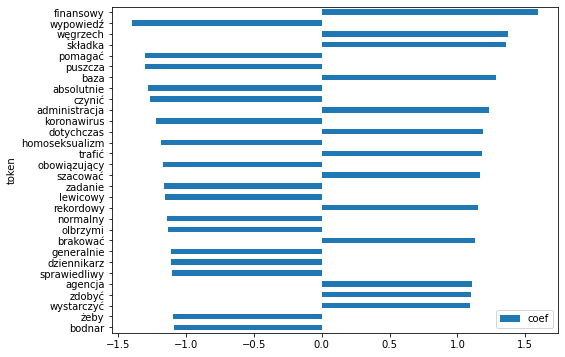

In [39]:
f, ax = plt.subplots(figsize=(8,6));

df_logreg_imp[df_logreg_imp['pvalue']<0.05].sort_values('coef_abs').tail(30)[['token', 'coef']].set_index('token').plot(kind='barh', ax=ax)
plt.show()

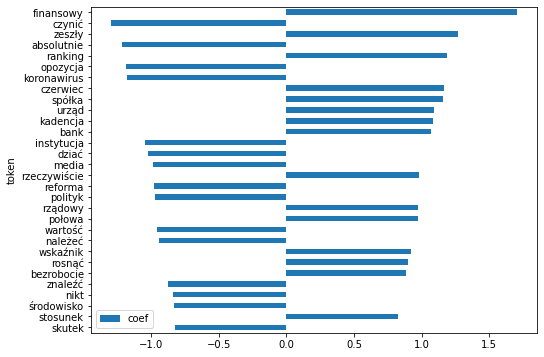

In [55]:
f, ax = plt.subplots(figsize=(8,6));

df_logreg_imp_20[df_logreg_imp_20['pvalue']<0.05].sort_values('coef_abs').tail(30)[['token', 'coef']].set_index('token').plot(kind='barh', ax=ax)
plt.show()

In [40]:
# masker = shap.maskers.Independent(data = X_train)
# explainer = explainer = shap.LinearExplainer(logisticRegr, masker)
# shap_values = explainer.shap_values(X_train)

# shap.summary_plot(shap_values, X_train)

### XGBoost

In [56]:
#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='multi:softmax' if False else 'binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)

xgbc0.fit(X_train_20 , y_train.sort_index().values)

train_predictions = xgbc0.predict(X_train_20)
test_predictions = xgbc0.predict(X_test_20)

In [57]:
print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      2303
           1       0.76      0.68      0.72      2079

    accuracy                           0.74      4382
   macro avg       0.75      0.74      0.74      4382
weighted avg       0.75      0.74      0.74      4382



In [58]:
print(classification_report(y_test.sort_index().values, test_predictions))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1135
           1       0.63      0.54      0.58      1024

    accuracy                           0.63      2159
   macro avg       0.63      0.63      0.63      2159
weighted avg       0.63      0.63      0.63      2159



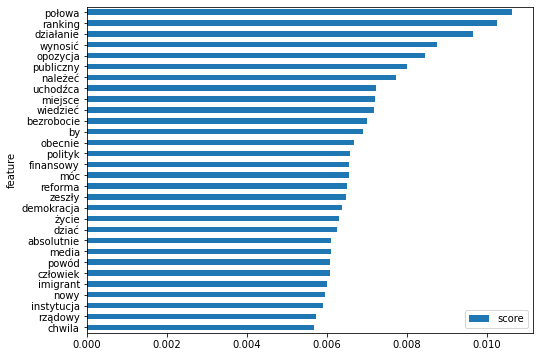

In [59]:
#plotting feature importance
features_list = df_one_trn_p_20.columns.values.tolist()

f, ax = plt.subplots(figsize=(8,6));
df_plot = pd.DataFrame({
    'feature' : features_list,
    'score' : xgbc0.feature_importances_
}).set_index('feature')
df_plot.sort_values('score').tail(30).plot(kind='barh', ax=ax)
plt.show()

### TfIdf approach

In [67]:
logisticRegr = LogisticRegression()

# cols = df_logreg_imp.sort_values('coef_abs').tail(2000)['token'].values
tfidf, _ =  get_tfidf(df_one_trn_p)
tfidf_tst, _ =  get_tfidf(df_one_tst_p)

X_train = tfidf.sort_index().values
X_test = tfidf_tst.sort_index().values

logisticRegr.fit(X_train, y_train.sort_index().values)

train_predictions = logisticRegr.predict(X_train)

print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      2303
           1       0.84      0.76      0.80      2079

    accuracy                           0.82      4382
   macro avg       0.82      0.82      0.82      4382
weighted avg       0.82      0.82      0.82      4382



In [76]:
X_test[np.isnan(X_test)] = 0

In [78]:
test_predictions = logisticRegr.predict(X_test)

print(classification_report(y_test.sort_index().values, test_predictions))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69      1135
           1       0.65      0.56      0.60      1024

    accuracy                           0.65      2159
   macro avg       0.65      0.65      0.64      2159
weighted avg       0.65      0.65      0.65      2159



## Investigate ngrams

In [96]:
df_trn_p_fn = df_one_trn[df_one_trn['index'].isin(y_train[y_train==0].index)]
df_trn_p_t = df_one_trn[df_one_trn['index'].isin(y_train[y_train==1].index)]

In [100]:
bigrams_fn = nltk.FreqDist(ngrams(df_trn_p_fn['tokens'].values, 2))
trigrams_fn = nltk.FreqDist(ngrams(df_trn_p_fn['tokens'].values, 3))

bigrams_t = nltk.FreqDist(ngrams(df_trn_p_t['tokens'].values, 2))
trigrams_t = nltk.FreqDist(ngrams(df_trn_p_t['tokens'].values, 3))

In [98]:
bigrams_fn.most_common(20)

[(('unia', 'europejski'), 65),
 (('trybunał', 'konstytucyjny'), 35),
 (('miliard', 'złoty'), 34),
 (('komisja', 'europejski'), 29),
 (('donald', 'tusk'), 27),
 (('być', 'by'), 26),
 (('mieć', 'być'), 26),
 (('prawo', 'sprawiedliwość'), 23),
 (('na', 'przykład'), 23),
 (('milion', 'złoty'), 22),
 (('ostatni', 'rok'), 21),
 (('by', 'być'), 20),
 (('platforma', 'obywatelski'), 18),
 (('jarosław', 'kaczyński'), 16),
 (('wielki', 'brytania'), 16),
 (('być', 'być'), 16),
 (('państwo', 'członkowski'), 15),
 (('wymiar', 'sprawiedliwość'), 15),
 (('chcieć', 'by'), 14),
 (('miejsce', 'praca'), 14)]

In [101]:
bigrams_t.most_common(20)

[(('miliard', 'złoty'), 80),
 (('unia', 'europejski'), 73),
 (('milion', 'złoty'), 45),
 (('trybunał', 'konstytucyjny'), 35),
 (('prawo', 'sprawiedliwość'), 33),
 (('na', 'przykład'), 29),
 (('ostatni', 'rok'), 26),
 (('mieć', 'być'), 24),
 (('przyp', 'red'), 22),
 (('wielki', 'brytania'), 20),
 (('miliard', 'euro'), 19),
 (('jarosław', 'kaczyński'), 17),
 (('procent', 'polak'), 16),
 (('ciąg', 'ostatni'), 16),
 (('stany', 'zjednoczone'), 15),
 (('andrzej', 'duda'), 14),
 (('lech', 'kaczyński'), 14),
 (('bronisław', 'komorowski'), 13),
 (('donald', 'tusk'), 13),
 (('między', 'innymi'), 13)]

In [99]:
trigrams_fn.most_common(20)

[(('chcieć', 'by', 'być'), 10),
 (('krajowy', 'rada', 'sądownictwo'), 8),
 (('kraj', 'unia', 'europejski'), 7),
 (('jan', 'paweł', 'ii'), 6),
 (('rząd', 'platforma', 'obywatelski'), 6),
 (('ciąg', 'ostatni', 'rok'), 6),
 (('rząd', 'prawo', 'sprawiedliwość'), 5),
 (('dziecko', 'zespół', 'down'), 5),
 (('mieć', 'być', 'czynić'), 5),
 (('rząd', 'donald', 'tusk'), 5),
 (('spółka', 'skarb', 'państwo'), 5),
 (('prezydent', 'andrzej', 'duda'), 4),
 (('ii', 'wojna', 'światowy'), 4),
 (('premier', 'beata', 'szydło'), 4),
 (('trybunał', 'sprawiedliwość', 'ue'), 4),
 (('warszawa', 'przyp', 'red'), 4),
 (('przewodniczący', 'rada', 'europejski'), 4),
 (('zgodnie', 'prawo', 'międzynarodowy'), 3),
 (('bliskiego', 'wschód', 'afryka'), 3),
 (('wschód', 'afryka', 'północny'), 3)]

In [102]:
trigrams_t.most_common(20)

[(('ciąg', 'ostatni', 'rok'), 10),
 (('rząd', 'prawo', 'sprawiedliwość'), 10),
 (('kraj', 'unia', 'europejski'), 10),
 (('kwota', 'wolny', 'podatek'), 7),
 (('prezydent', 'bronisław', 'komorowski'), 6),
 (('hanna', 'gronkiewicz', 'waltz'), 6),
 (('plan', 'zagospodarować', 'przestrzenny'), 6),
 (('wysoki', 'izba', 'kontrola'), 5),
 (('chcieć', 'by', 'być'), 5),
 (('spółka', 'skarb', 'państwo'), 5),
 (('narodowy', 'bank', 'polska'), 5),
 (('miliard', 'złoty', 'budżet'), 5),
 (('międzynarodowy', 'fundusz', 'walutowy'), 5),
 (('główny', 'urząd', 'statystyczny'), 5),
 (('prezydent', 'lech', 'kaczyński'), 5),
 (('najwyższ', 'izba', 'kontrola'), 5),
 (('prezydent', 'andrzej', 'duda'), 5),
 (('procent', 'polak', 'uważać'), 4),
 (('milion', 'złoty', 'rocznie'), 4),
 (('program', 'in', 'vitro'), 4)]